## How bad is the scaling estimate for $\Phi_{Tr}$ for profiles other than linear?

Comparison between estimated tracer flux onto the shelf through the canyon and the real deal.

$\Phi_{Tr}=\Phi \bar{C}$

where $\frac{\Phi}{WUD_h} = 0.9\mathcal{F}_w^{3/2}R_o^{1/2}(1-1.21S_E)^3+0.07$, $\mathcal{F}_w=R_w/(0.9+R_w)$, $R_w=U/fW$, $S_E=sN/f(\mathcal{F}_w/R_o)^{1/2}$.

And, $\bar{C}$ is 
$\frac{\bar{C}}{C_0}= 0.02\frac{\partial_zC}{2} (H_s+H_r) + 0.94$

where
$\frac{\partial_zC}{\partial_zC_0}= 5.81\frac{Z+Z_{dif}}{H_s}+1.03$


In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh = 97.5 # head depth
Hr = 132.0 # rim depth at DnS
No = 5.5E-3
f = 9.66E-5
kv = 1E-5
t = 6 # days
U = 0.35 # m/s

# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)


In [4]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

ptracers_fileNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'
ptracersNoC = xr.open_dataset(ptracers_fileNoC)

time = state.variables['T']


In [5]:
fileBAR = ('/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run01.csv')
fileBARNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run02.csv') 

fileLWR = ('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOWER_SR_7Tr/HCW_TrMass_CNTDIFF_LOWER_SR_7Tr_run01.csv')
fileLWRNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOWER_SR_7Tr/HCW_TrMass_CNTDIFF_LOWER_SR_7Tr_run02.csv') 

dfBAR = pd.read_csv(fileBAR)
dfBARnoc = pd.read_csv(fileBARNoC)

dfLWR = pd.read_csv(fileLWR)
dfLWRnoc = pd.read_csv(fileLWRNoC)                

In [6]:
Mass_Bark = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07','TrMassHCW08']
labels_Bark = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Acid','Methane']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']
dTr0_Bark = [ -0.001673,-0.00196495056152,0.286328125,-0.0376,-0.08477,-0.00222,-0.046969,-0.23884]
Co_Bark = [32.24,33.89,104.070,32.60, 47.6260, 2.24576, 27.667, 17.5046 ]
Cd6_Bark = [32.2081,33.8268,112.498 ,31.67298 ,44.8990 ,2.17560 ,25.5802,16.2077]


Mass_Para = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07']
labels_Para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours_Para = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7'] 
dTr0_Para = [-0.05,-0.05180,-0.050294,-0.049734,-0.04855,-0.0625,-0.0375]
Co_Para = [13.625,13.627 ,13.625 ,13.624 ,13.623,13.640, 150.10]
Cd6_Para =  [12.595 ,12.8862,12.6462,12.5458 ,12.3310 ,15.1507 ,146.4252] 


In [7]:
Z = ((f*U*F(Ro(U,f,R))*L)**(0.5))/No
Zdif = np.sqrt(t*3600*24*kv)
    
Se = (s*No)/(f*((F(Ro(U,f,W))/Ro(U,f,L))**(1/2)))
HA2013=(U*W*Dh(f,L,No))*((0.91*(F(Ro(U,f,W))**(3/2))*(Ro(U,f,L)**(1/2))*((1-1.21*Se)**3))+0.07)

Tr1 18.0366987086
Tr2 18.2276250841
Tr3 18.067446397
Tr4 18.0075576189
Tr5 17.8824266174
Tr6 19.3652945308
Tr7 184.299654651
Linear 30.7196183632
Salinity 32.3677540742
Oxygen -130.901600311
Nitrate 40.0527964904
Silicate 75.757965088
Phosphate 2.14928320902
Nitrous Acid 35.9817298688
Methane 48.5456663484


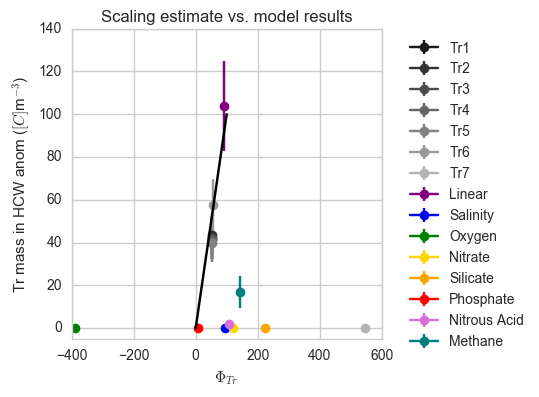

In [13]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

for TrMass, dTr0,Co, lab, col in zip(Mass_Para,dTr0_Para,Co_Para,labels_Para,colours_Para):
    
    mass_can_eff = dfLWR[TrMass]-dfLWRnoc[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    
    dTrdz = -dTr0*(5.81*(((Z+Zdif)/Hs))+1.03)
    Capprox=((0.02*(dTrdz*(Hh+132.0)/2.0))+0.94)*Co
    scale_PhiTr = HA2013*Capprox
    print(lab,Capprox)
    ax.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')

for TrMass, dTr0, Co, lab, col in zip(Mass_Bark,dTr0_Bark,Co_Bark,labels_Bark,colours_Bark):
    
    mass_can_eff = dfBAR[TrMass]-dfBARnoc[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    
    dTrdz = -dTr0*(5.81*(((Z+Zdif)/Hs))+1.03)
    Capprox=((0.02*(dTrdz*(Hh+132.0)/2.0))+0.94)*Co
    print(lab,Capprox)
    scale_PhiTr = HA2013*Capprox
    
    ax.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')

ax.legend(bbox_to_anchor=(1.5,1),ncol=1, columnspacing=0.1)
ax.set_xlabel(r'$\Phi_{Tr}$')
ax.set_ylabel('Tr mass in HCW anom ($[C]$m$^{-3}$)')

ax.set_title('Scaling estimate vs. model results')
ax.set_ylim(-5,140)
ax.plot(np.arange(0,140,50),np.arange(0,140,50),'-k')

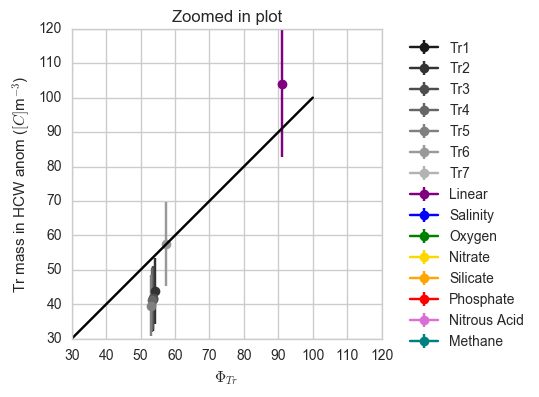

In [17]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

for TrMass, dTr0,Co, lab, col in zip(Mass_Para,dTr0_Para,Co_Para,labels_Para,colours_Para):
    
    mass_can_eff = dfLWR[TrMass]-dfLWRnoc[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    
    dTrdz = -dTr0*(5.81*(((Z+Zdif)/Hs))+1.03)
    Capprox=((0.02*(dTrdz*(Hh+132.0)/2.0))+0.94)*Co
    scale_PhiTr = HA2013*Capprox
    ax.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')

for TrMass, dTr0, Co, lab, col in zip(Mass_Bark,dTr0_Bark,Co_Bark,labels_Bark,colours_Bark):
    
    mass_can_eff = dfBAR[TrMass]-dfBARnoc[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    
    dTrdz = -dTr0*(5.81*(((Z+Zdif)/Hs))+1.03)
    Capprox=((0.02*(dTrdz*(Hh+132.0)/2.0))+0.94)*Co
    scale_PhiTr = HA2013*Capprox
    
    ax.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')

ax.legend(bbox_to_anchor=(1.5,1),ncol=1, columnspacing=0.1)
ax.set_xlabel(r'$\Phi_{Tr}$')
ax.set_ylabel('Tr mass in HCW anom ($[C]$m$^{-3}$)')

ax.set_title('Zoomed in plot')
ax.set_ylim(30,120)
ax.set_xlim(30,120)
ax.plot(np.arange(0,140,50),np.arange(0,140,50),'-k')

Tr1 18.0366987086
Tr2 18.2276250841
Tr3 18.067446397
Tr4 18.0075576189
Tr5 17.8824266174
Tr6 19.3652945308
Tr7 184.299654651
Linear 30.7196183632
Salinity 32.3677540742
Oxygen -130.901600311
Nitrate 40.0527964904
Silicate 75.757965088
Phosphate 2.14928320902
Nitrous Acid 35.9817298688
Methane 48.5456663484


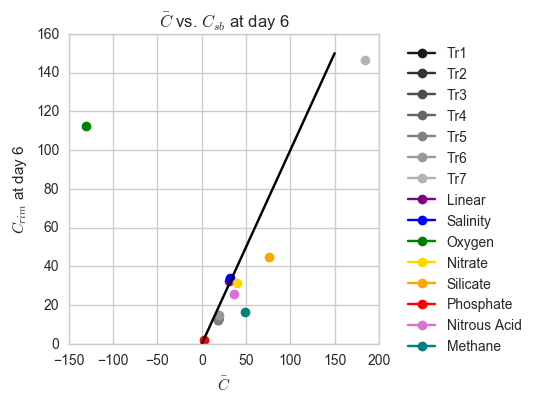

In [19]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

for C,dTr0,Co, lab, col in zip(Cd6_Para,dTr0_Para,Co_Para,labels_Para,colours_Para):
    
    dTrdz = -dTr0*(5.81*(((Z+Zdif)/Hs))+1.03)
    Capprox=((0.02*(dTrdz*(Hh+132.0)/2.0))+0.94)*Co
    print(lab,Capprox)
    ax.plot(Capprox, C, color=col, label=lab, marker='o')

for C,dTr0,Co, lab, col in zip(Cd6_Bark,dTr0_Bark,Co_Bark,labels_Bark,colours_Bark):
    
    dTrdz = -dTr0*(5.81*(((Z+Zdif)/Hs))+1.03)
    Capprox=((0.02*(dTrdz*(Hh+132.0)/2.0))+0.94)*Co
    print(lab,Capprox)
    ax.plot(Capprox, C, color=col, label=lab, marker='o')

ax.legend(bbox_to_anchor=(1.5,1),ncol=1, columnspacing=0.1)
ax.set_xlabel(r'$\bar{C}$')
ax.set_ylabel('$C_{rim}$ at day 6')
ax.set_title(r'$\bar{C}$ vs. $C_{sb}$ at day 6')
ax.plot(np.arange(0,160,50),np.arange(0,160,50),'-k')